In [63]:
from keras.preprocessing.text import Tokenizer
import random 
from keras.preprocessing.sequence import pad_sequences
import numpy as np
docs = ['this is a test ', 'this is also a test', 'why and I still testing this', 'ok now the test is over']


class SkipGram:
    def __init__(self, max_len=5, tokenizer=None):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.words = None
        self.probs = None
        self.n_words = None
        if tokenizer:
            self._setup_words()
        pass

    def _setup_words(self):
        self.n_words = sum(self.tokenizer.word_counts.values())
        self.words = np.array(list(self.tokenizer.word_counts.keys()))
        p = np.log(np.array(list(self.tokenizer.word_counts.values())))
        self.probs = p/p.sum()
    def fit(self, docs):
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(docs)
        self._setup_words()

    def _text_to_padded_sequences(self, docs):
        seqs = self.tokenizer.texts_to_sequences(docs)
        seqs_padded = pad_sequences(seqs, maxlen=self.max_len, padding='post', truncating='post')
        return seqs_padded
    def text_to_seq(self, docs):
        seqs = self.tokenizer.texts_to_sequences(docs)
        seqs_padded = pad_sequences(seqs, maxlen=self.max_len-1, padding='post', truncating='post')
        return seqs_padded
    def _random_choice_int(self, v):
        new_word = np.random.choice(self.words, 1, p=self.probs)[0]
        output = self.tokenizer.word_index[new_word]
        if v == output:
            new_word = np.random.choice(self.words, 1, p=self.probs)[0]
            output = self.tokenizer.word_index[new_word]
        
        return output

    def _missing_word_gen(self, docs):
        seqs = self._text_to_padded_sequences(docs)
        for seq in seqs:
            seq = np.array(seq)
            if sum(seq) != 0:
                for i in range(self.max_len):
                    new_seq = np.delete(seq, i)
                    x = np.array([new_seq, new_seq])
                    word_index = seq[i]
                    new_word_index = self._random_choice_int(word_index)
                    context = np.array([[word_index], [new_word_index]])
                    label = np.array([[1], [0]])
                    yield x, context, label

    def array_to_texts(self, x):
        return list(s.tokenizer.sequences_to_texts_generator(x))
    
    def transform_gen(self, docs, batch_size=32, shuffle=True):
        if shuffle:
            random.shuffle(docs)
        gen = self._missing_word_gen(docs)
        try:
            while True:
                array_list = [next(gen) for _ in range(int(batch_size))]
                x = np.vstack([v[0] for v in array_list])
                context = np.vstack([v[1] for v in array_list])
                labels = np.vstack([v[2] for v in array_list]).flatten()
                yield x, context, labels
        except StopIteration:
            print('completed')

    def transform(self, docs):
        array_list = list(self._missing_word_gen(docs))
        x = np.vstack([v[0] for v in array_list])
        context = np.vstack([v[1] for v in array_list])
        labels = np.vstack([v[2] for v in array_list]).flatten()
        return x, context, labels

test_docs = ['this is a test', 'this is still a test', 'why am I still testing', '']
s = SkipGram(max_len = 7)
s.fit(test_docs)
test_x, test_context, test_labels = s.transform(test_docs)
list(zip(s.array_to_texts(test_x,), s.array_to_texts( test_context),test_labels ))[1:10]


[('is a test', 'a', 0),
 ('this a test', 'is', 1),
 ('this a test', 'test', 0),
 ('this is test', 'a', 1),
 ('this is test', 'a', 0),
 ('this is a', 'test', 1),
 ('this is a', 'a', 0),
 ('this is a test', '', 1),
 ('this is a test', 'is', 0)]

## Download 2020 ICD 10 Codes from the CDC

In [64]:
from urllib import request as ur
import pandas as pd
import re
url = 'ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Publications/ICD10CM/2020/icd10cm_codes_2020.txt'
req = ur.Request(url)
file = ur.urlopen(req)


df = pd.read_csv(file,  header=None, sep='\t')

# parses out the code descripitions
docs = list(map(lambda x: re.sub('[A-Z][0-9]+', '', x).strip(), df.iloc[:, 0]))
# parest out the actuall codes 
codes = list(map(lambda x: re.search('[A-Z][0-9]+', x).group(), df.iloc[:, 0]))
 

In [65]:
# calculated the max sequence len
np.max([len(d.split(' ')) for d in docs])

31

In [66]:
max_len = 31
s = SkipGram(max_len=max_len)
s.fit(docs)
vocab_size = len(s.tokenizer.word_index)
context_size = 1

In [67]:
vocab_size

7212

In [68]:

from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Flatten, Dense, BatchNormalization
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from keras.callbacks import EarlyStopping
esm =  EarlyStopping(patience=2, monitor='loss')

dim_embedddings =10
n_w_inputs = max_len-1 

# inputs
w_inputs = Input(shape=(n_w_inputs, ), dtype='int32')
w = Embedding(vocab_size+1, dim_embedddings,name= 'embx')(w_inputs)

# context
c_inputs = Input(shape=(context_size, ), dtype='int32')
c  = Embedding(vocab_size+1, dim_embedddings, name= 'embc')(c_inputs)
o = Dot(axes=2)([w, c])
o = BatchNormalization()(o)
o = Reshape((1, n_w_inputs), input_shape=(n_w_inputs, 1))(o)
o = Flatten(name='flatten')(o)
o = Dense(1)(o)
o = Activation('sigmoid')(o)

model = Model(inputs=[w_inputs, c_inputs], outputs=o)
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 30)           0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embx (Embedding)                (None, 30, 10)       72130       input_19[0][0]                   
__________________________________________________________________________________________________
embc (Embedding)                (None, 1, 10)        72130       input_20[0][0]                   
__________________________________________________________________________________________________
dot_7 (Dot

In [69]:
# define training function
def train(doc, n_epochs=1, skipgram=s, model=model, batch_size=1024):
    for e in range(n_epochs):
        gen = s.transform_gen(docs, batch_size=batch_size)
        try:
            batch = 0
            while True:
                x, context, y = next(gen)
                model.train_on_batch([x, context], y)
                if batch % 100 == 0:
                    results = model.evaluate([x, context], y)
                    print('epoch {0} batch {1} results {2} ...'.format(e, batch, results))
                batch +=1
        except StopIteration:
            pass
    return model


In [82]:
model = train(docs, 1, s,  model)

2048/2048 [==============================] - 0s 81us/step
epoch 0 batch 0 results 0.07324287738401836 ...
2048/2048 [==============================] - 0s 74us/step
epoch 0 batch 100 results 0.055996437936300936 ...
2048/2048 [==============================] - 0s 82us/step
epoch 0 batch 200 results 0.07172092154451093 ...
2048/2048 [==============================] - 0s 72us/step
epoch 0 batch 300 results 0.0817420346822928 ...
2048/2048 [==============================] - 0s 72us/step
epoch 0 batch 400 results 0.06585582592015271 ...
2048/2048 [==============================] - 0s 75us/step
epoch 0 batch 500 results 0.05984575255570235 ...
2048/2048 [==============================] - 0s 80us/step
epoch 0 batch 600 results 0.0684957798061987 ...
2048/2048 [==============================] - 0s 87us/step
epoch 0 batch 700 results 0.08176447088953864 ...


KeyboardInterrupt: 

In [71]:
emb_input = Input(shape=(max_len-1, ), dtype='int32')
emb_layer = model.get_layer('embx')(emb_input )
emb_model = Model(inputs=emb_input, outputs=emb_layer)

seqs = s.text_to_seq(docs)
seqs[1:3]

array([[1531,   82,   11,  107,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [  15,   19,  124,   11,   26,   54,    9,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])

In [72]:
vects = emb_model.predict(seqs)
vects.shape

(72184, 30, 10)

In [73]:
vecs_reshape = np.reshape(vects, (vects.shape[0], -1))
vecs_reshape.shape

(72184, 300)

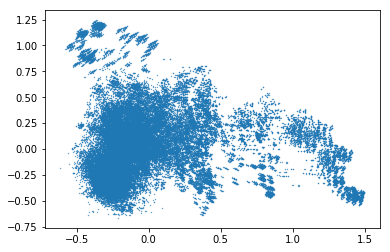

In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
p = PCA(2).fit(vecs_reshape)
comps = p.transform(vecs_reshape)
xx = comps[:, 0]
yy = comps[:, 1]
plt.scatter(xx, yy,s=.1)
plt.show()

In [90]:
vect_dict = dict(zip(codes, np.reshape(vects, (-1, (max_len-1) * dim_embedddings ))))
code_dict = dict(zip(codes, docs))

In [ ]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(5)
nn = nn.fit(vect_dict.values())

In [89]:
np.reshape(vects, (-1, 300))

array([[-0.1084013 , -0.0636738 ,  0.02138013, ..., -0.01035827,
        -0.01078706, -0.01088057],
       [-0.19157313,  0.3156744 ,  0.01905485, ..., -0.01035827,
        -0.01078706, -0.01088057],
       [ 0.12143321,  0.374708  ,  0.06084458, ..., -0.01035827,
        -0.01078706, -0.01088057],
       ...,
       [ 0.10221165,  0.3208326 ,  0.14370155, ..., -0.01035827,
        -0.01078706, -0.01088057],
       [ 0.01153841,  0.02142074,  0.07053322, ..., -0.01035827,
        -0.01078706, -0.01088057],
       [-0.12254233, -0.02010527,  0.0358062 , ..., -0.01035827,
        -0.01078706, -0.01088057]], dtype=float32)

array([[ 0.23787682,  0.5360314 , -1.1291488 , -1.0371948 , -0.3604317 ,
        -0.54900056,  2.8635721 , -1.3182254 ,  0.22442229, -0.85865223,
         0.6123756 ,  1.3411671 , -0.7237421 ,  1.2181327 ,  0.5400485 ,
        -0.09770048,  0.37835634,  0.88989913,  0.5764348 ,  0.23933786,
         1.3342005 , -1.1772667 , -0.70607245, -2.7991874 ,  0.08042213,
        -0.03354798,  0.03073583, -0.13060476, -0.17602329, -1.1250391 ]],
      dtype=float32)

In [92]:
codes[1:10]

['A001', 'A009', 'A0100', 'A0101', 'A0102', 'A0103', 'A0104', 'A0105', 'A0109']

In [93]:
docs[1:10]

['XS Fracture of unspecified shoulder girdle, part unspecified, sequela',
 'A Laceration without foreign body, right thigh, initial encounter',
 'S Poisoning by antimalarials and drugs acting on other blood protozoa, undetermined, sequela',
 'A Injury of digital nerve of left little finger, initial encounter',
 'A Corrosion of second degree of right wrist, initial encounter',
 'S Other osteoporosis with current pathological fracture, right humerus, sequela',
 'R Nondisplaced fracture of olecranon process without intraarticular extension of left ulna, subsequent encounter for open fracture type IIIA, IIIB, or IIIC with malunion',
 'A Major laceration of body of pancreas, initial encounter',
 'D Poisoning by anticholinesterase agents, accidental (unintentional), subsequent encounter']